In [267]:
import numpy as np
import pandas as pd
from numba import njit

from math import log, sqrt, pi, exp
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

# Binomial Tree

In [268]:
def buildTree(S, vol , T, N, r):
    dt = T / N
    matrix = np.zeros((N + 1, N + 1))
    prob_matrix = np.zeros((N + 1, N + 1))  ;   prob_matrix[0,0] = 1
    u = np.e **  (vol * np.sqrt(dt)) # TODO
    d = np.e ** (-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO

    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            matrix[i, j] = S * d ** (i-j) * u ** (j)

    # Iterate over the lower triangle
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            prob_matrix[i, j] = prob_matrix[i-1, j]*(1-p) + prob_matrix[i-1, j-1]*p

    return matrix, prob_matrix

Visualisation 2 Shape = (11, 1)


,Probabilities 1Y,Probabilities 0.5Y
S Value,,
36,1.042276e-20,NaN
37,7.210140e-19,NaN
38,2.452311e-17,NaN
39,5.466284e-16,NaN
40,8.980839e-15,NaN
...,...,...
156,1.470383e-11,NaN
160,1.189667e-12,NaN
164,7.094612e-14,NaN


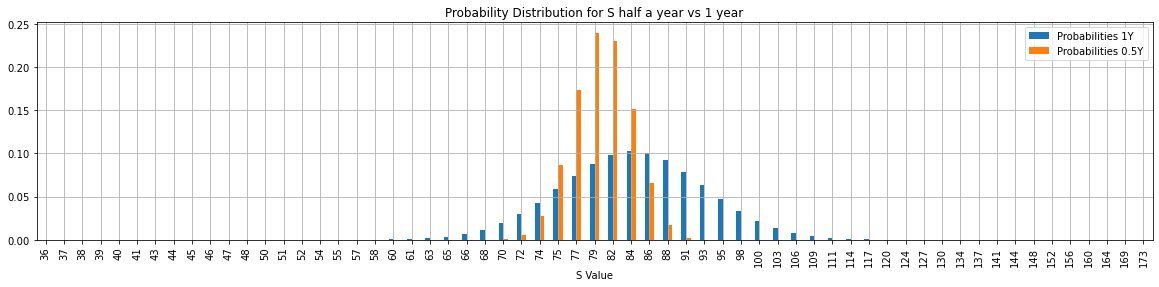

In [269]:
sigma = 0.1
S = 80
T =1.
N = 60
r = 0.06

tree, prob_tree = buildTree(S, sigma, T, N, r)

visualisation = pd.DataFrame()
visualisation['S Value'] = tree[-1,:].astype(int)
visualisation['Probabilities'] = prob_tree[-1,:]
visualisation.set_index('S Value', inplace=True)
# visualisation.plot.bar('Values', 'Probabilities', figsize=(20,4))
# print(visualisation)

visualisation_2 = pd.DataFrame() # prob_tree.take([25,-1],axis=0)).T
visualisation_2['S Value'] = tree[10,:].astype(int)
visualisation_2['Probabilities'] = prob_tree[10,:]
visualisation_2 = visualisation_2[visualisation_2['S Value'] > 0]
visualisation_2.set_index('S Value', inplace=True)
print(f'Visualisation 2 Shape = {visualisation_2.shape}')

visualisation_3 = visualisation.join(visualisation_2, lsuffix=' 1Y', rsuffix=' 0.5Y', how='outer')
# visualisation_3 = visualisation_3[visualisation_3['Probabilities 1Y'] > 0.000001]
visualisation_3.plot(kind='bar', figsize=(20,4), grid=True, title="Probability Distribution for S half a year vs 1 year")
visualisation_3
# visualisation_2.plot.bar('Values', 'Probabilities', figsize=(20,4))

## Full Binomial Tree

In [270]:
@njit
def call_bt(T, r , K, vol, N, S ):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        tree[rows-1, c] = max(0, _S - K) # TODO
    # print( tree )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [271]:
sigma = 0.2
S = 100
T=1.
N=10_000

K = 99
r = 0.06

# tree = buildTree(S, sigma, T, N)
V_bt, D_bt = call_bt(T, r , K, sigma, N, S)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')
# option_value_tree

Option Value with N(10000) steps = 11.54445
Delta with N(10000) steps        = 0.67373


# Black-Scholes Formula

In [272]:
def bs_call(S,K,T,r,sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    V = S*norm.cdf(d1) -K*exp(-r*T)*norm.cdf(d2)
    D = norm.cdf(d1)

    return V, D

In [273]:
sigma = 0.2
S = 100
T=1.

K = 99
r = 0.06
bs_result, bs_D = bs_call(S,K,T,r,sigma)
print(f'Option Value with Black-Scholes Formula = {bs_result}')
print(f'Delta Value with Black-Scholes Formula = {bs_D}')

Option Value with Black-Scholes Formula = 11.544280227051097
Delta Value with Black-Scholes Formula = 0.6737355117348961


# Tests
## Option Value Convergence with n

In [274]:

T=1.
r = 0.06
K = 99
sigma = 0.2
S = 100

NN = np.log2(10_000) ;   size = 50   ;
values = np.zeros((size, 3))
for n in tqdm(np.append(np.logspace(1, NN, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    V_bt, _ = call_bt(T, r, K, sigma, n, S)
    values[size-1] = [n, V_bt, perf_counter() - _st]
    size -= 1
values = values[::-1]

100%|██████████| 51/51 [00:02<00:00, 18.04it/s] 


Option Value with N(9999) = 11.54410 EUR
Option Value with N(50)   = 11.54643 EUR
Difference with (9999)    = -0.00233 EUR
Option Value Black-Scholes Formula = 11.54428 EUR


,Binary_Tree,Execution_Time,Black_Scholes
2.0,10.842582,1.416018e-06,11.54428
2.0,10.842582,8.750358e-07,11.54428
3.0,12.105041,1.250010e-06,11.54428
4.0,11.221167,7.791969e-06,11.54428
4.0,11.221167,1.124979e-06,11.54428
5.0,11.877161,4.625006e-06,11.54428
6.0,11.349620,2.000015e-06,11.54428
8.0,11.412268,2.124987e-06,11.54428
9.0,11.724538,2.000015e-06,11.54428
11.0,11.689917,6.000046e-06,11.54428


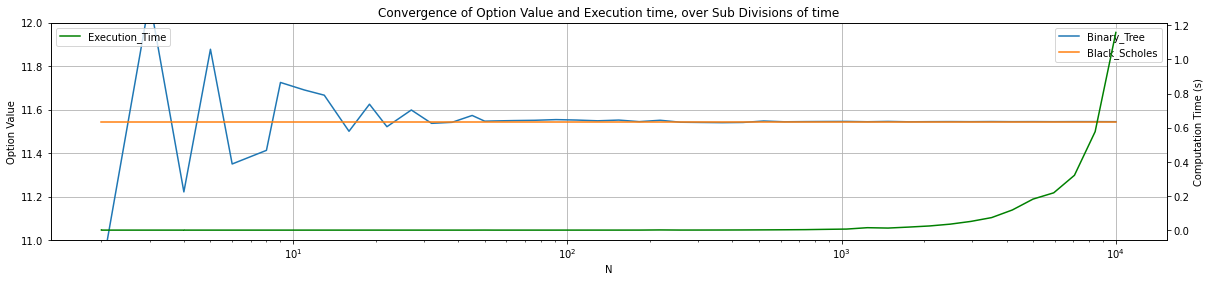

In [275]:
_results_df = pd.DataFrame(values[:, 1:], columns=['Binary_Tree', 'Execution_Time'] , index=values[:, 0]).sort_index()
_results_df["Black_Scholes"] = bs_result
_results_df

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

_results_df[['Binary_Tree', 'Black_Scholes']].plot(figsize=(20,4), ylim=(11,12), ax=ax_left, xlabel='N', ylabel='Option Value', legend='Option Value - USD',
                              title='Convergence of Option Value and Execution time, over Sub Divisions of time', grid=True, logx=True)
_results_df.Execution_Time.plot(ax=ax_right, color='green', ylabel='Computation Time (s)', legend='Computation Time')

print(f'Option Value with N({int(2**NN)}) = {_results_df.iloc[-1].Binary_Tree:.5f} EUR')
print(f'Option Value with N(50)   = {_results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
print(f'Difference with ({int(2**NN)})    = {_results_df.iloc[-1].Binary_Tree - _results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
print(f'Option Value Black-Scholes Formula = {_results_df.iloc[-1].Black_Scholes:.5f} EUR')
# print(f'% Difference = {(_results_df.iloc[-1].Option_Value - _results_df[_results_df.index == 50.0].Option_Value.values[0]) / _results_df[_results_df.index == 50.0].Option_Value.values[0] * 100}')
_results_df

## Option Value accuracy for different Levels of Volatility

In [276]:
V_df = np.zeros((50,0))
D_df = np.zeros((50,0))
Inx_df = np.zeros((50,0))

_S = 100    ; _T = 1.   ; _K = 99   ; _r = 0.06

volatility = [10., 5., 1., .5, .1, .05]
for inx, vol in enumerate(volatility):
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)

    _N = np.log2(100) ;   size = 50
    values = np.zeros((size, 3))
    for n in tqdm(np.append(np.logspace(1, _N, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
        V_bt, D_bt = call_bt(_T, _r, _K, vol, n, _S)

        V_diff = (V_bt - V_bs)/V_bs * 100
        D_diff = (D_bt - D_bs)/D_bs * 100

        values[size-1] = [n, V_diff, D_diff]    ;   size -= 1
    # values = values[::-1]

    V_df = (np.insert(V_df, inx, values[:,1], axis=1))
    D_df = (np.insert(D_df, inx, values[:,2], axis=1))

columns = [f'σ {v}' for v in volatility]
V_df = pd.DataFrame(V_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
D_df = pd.DataFrame(D_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
V_df
# values_df.sort_index(inplace=True)
# values_df

100%|██████████| 51/51 [00:00<00:00, 34691.78it/s]


,σ 10.0,σ 5.0,σ 1.0,σ 0.5,σ 0.1,σ 0.05
2.0,-0.163003,-4.294319,-9.853122,-8.649692,-4.017578,-2.060112
3.0,-0.005498,-0.364255,6.490177,6.718843,2.014428,-0.590886
4.0,-0.025652,-1.975455,-5.081738,-4.340992,-1.657787,-0.921635
5.0,-0.002680,-0.300917,3.883853,4.008302,1.182492,-0.315301
6.0,-0.008496,-1.255810,-3.379828,-2.823391,-0.893034,-0.513132
7.0,-0.001534,-0.244843,2.765556,2.848853,0.801207,-0.259406
8.0,-0.003983,-0.914683,-2.514319,-2.059443,-0.535779,-0.322242
9.0,-0.000995,-0.204322,2.145762,2.206993,0.584318,-0.242441
10.0,-0.002276,-0.717453,-1.992381,-1.602826,-0.336838,-0.217633
11.0,-0.000704,-0.174690,1.752280,1.799739,0.444696,-0.236492


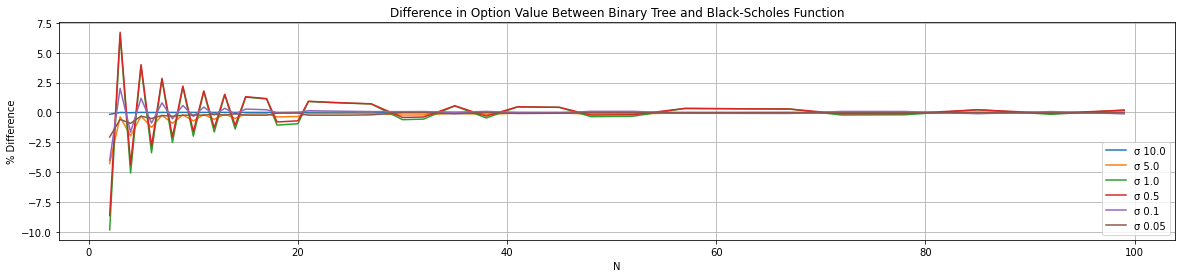

In [277]:
V_df.plot(figsize=(20,4), xlabel='N', ylabel='% Difference', legend='Option Value - USD',
                              title='Difference in Option Value Between Binary Tree and Black-Scholes Function', grid=True, logx=False)
inx = [50.0]
# values_df[values_df.where(values_df.index == 50.0)]
# values_df[(values_df.index == 50.0)]

<AxesSubplot:title={'center':'Difference in Option Delta Between Binary Tree and Black-Scholes Function'}, xlabel='N', ylabel='% Difference'>

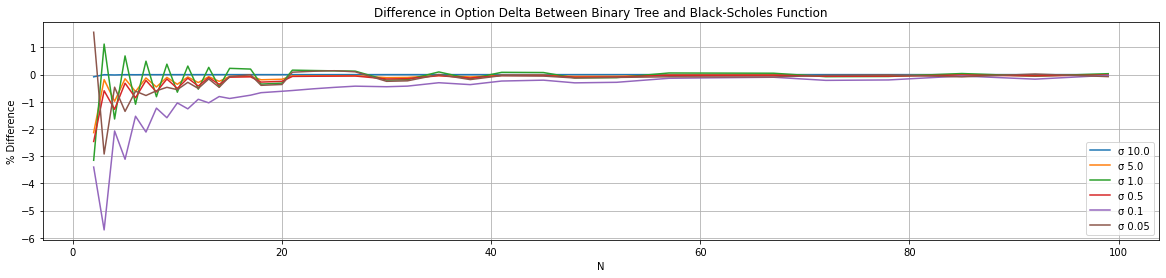

In [278]:
D_df.plot(figsize=(20,4), xlabel='N', ylabel='% Difference', legend='Option Value - USD',
                              title='Difference in Option Delta Between Binary Tree and Black-Scholes Function', grid=True, logx=False)

<AxesSubplot:title={'center':'% Difference Between Binomial Tree (50) and Black-Scholes Formula'}, xlabel='Volatility (σ)', ylabel='% Difference'>

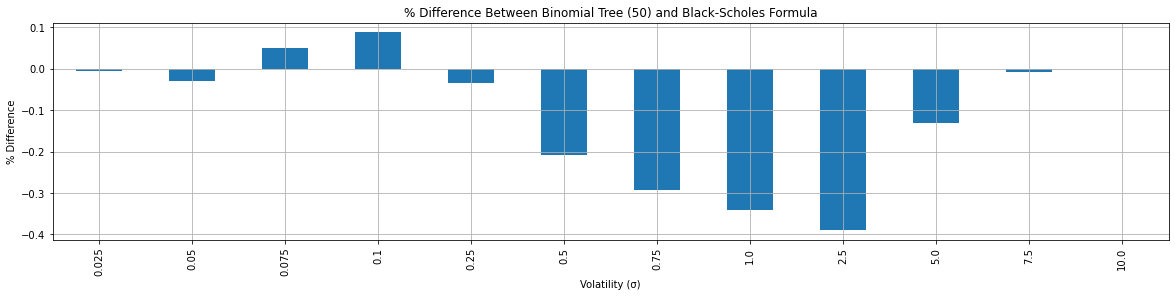

In [279]:
values_df = pd.DataFrame()
_S = 100    ;    _T=1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", (V_bt - V_bs)/V_bs*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,4), grid=True, title="% Difference Between Binomial Tree (50) and Black-Scholes Formula",
            ylabel='% Difference', xlabel='Volatility (σ)', legend=False)
# values

<AxesSubplot:title={'center':'% Difference in Delta Between Binomial Tree (50) and Black-Scholes Formula'}, xlabel='Volatility (σ)', ylabel='% Difference'>

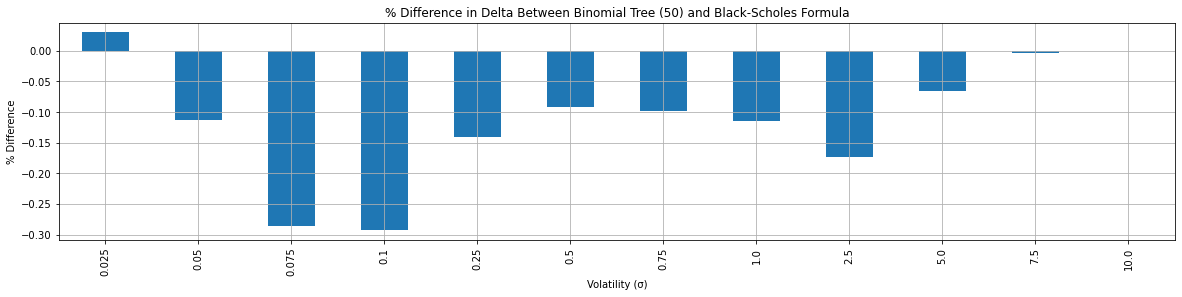

In [280]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", (D_bt - D_bs)/D_bs*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,4), grid=True, title="% Difference in Delta Between Binomial Tree (50) and Black-Scholes Formula",
            ylabel='% Difference', xlabel='Volatility (σ)', legend=False)
# values

--------------------------------------------------------------------------------------------------------------------------------------------
# American options

In [306]:
@njit
def option_contract_bt(T, r , K, vol, N, S ,type="C", american=False):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            # tree[i, j] = max(tree[i, j], S * d ** (i-j) * u ** (j)) # TODO
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) # TODO
        else: tree[rows-1, c] = max(0, K- _S) # TODO
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "C":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    # print(tree)
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [307]:
sigma = 0.2
S = 100
T=1.
N=5

K = 99
r = 0.06

# tree = buildTree(S, sigma, T, N)
V_bt, D_bt = option_contract_bt(T, r , K, sigma, N, S, type="C", american=True)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')

Option Value with N(5) steps = 11.87716
Delta with N(5) steps        = 0.65949


## Difference between European and American Options for different levels of volatility

[2.5, 5.0, 7.5, 10.0, 0.25, 0.5, 0.75, 1.0, 0.025, 0.05, 0.07500000000000001, 0.1]


100%|██████████| 12/12 [00:00<00:00, 85.45it/s]

[[1.00000000e+02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.23987310e+01 1.08226595e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.53752549e+01 1.00000000e+02 1.17129958e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.42843367e-33 6.35832207e-33 7.44749996e-33 ... 1.84215201e+36
  0.00000000e+00 0.00000000e+00]
 [5.01580382e-33 5.87500890e-33 6.88139545e-33 ... 1.70212508e+36
  1.99369839e+36 0.00000000e+00]
 [4.63453908e-33 5.42843367e-33 6.35832207e-33 ... 1.57274197e+36
  1.84215201e+36 2.15771187e+36]]
108.22659461667432 92.39873097198344
[[1.00000000e+02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.23987310e+01 1.08226595e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.53752549e+01 1.00000000e+02 1.17129958e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.42843367e-33 6.35832207e-33 7.44749996e-33 ... 1.84215201

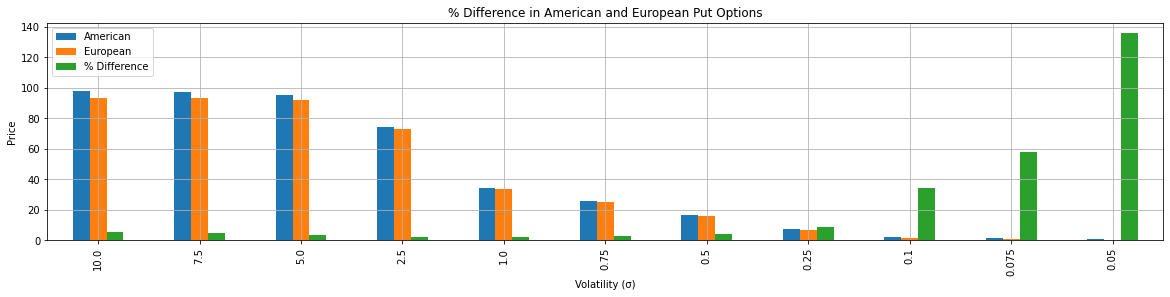

In [283]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)

N = 1_000 ;   size = len(space)
values = np.zeros((size, 4))
for vol in tqdm(space):
    american_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=True)
    european_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=False)
    values[size-1] = [f"{vol:.3f}", american_put_option_value, european_put_option_value, (american_put_option_value - european_put_option_value)/european_put_option_value*100]
    size -= 1

values = pd.DataFrame(values[::-1][:,1:], index=values[::-1][:,0], columns=['American','European', '% Difference'])
values.sort_index(inplace=True, ascending=False)
values.iloc[:-1,:].plot(kind='bar', figsize=(20,4), grid=True, title="% Difference in American and European Put Options",
            ylabel='Price', xlabel='Volatility (σ)', legend=True)
print(values.to_latex(float_format='%.5f'))

------------------------------------------------------------------------------------------------------------------------------------
# Geometric Brownian Motion - Hedging Simulations

Consider again a short position in a European call option on a non-dividend-paying stock with a maturity of one year and strike price K of e99. Let the one year interest rate be 6% and the current price of the stock be e100. Furthermore, assume that the volatility is 20%.

In [284]:
""" Euler's Method """
def gbm_euler(S0, r, sigma, T, M):
    dt = T / M
    Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
    for m in range(1, M+1):
        zm = norm.rvs(loc=0., scale=1)
        Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm
        Sm[m, 1] = m * dt
    return Sm

<AxesSubplot:title={'center':'Simulated Geometric Brownian Motion'}, xlabel='Time', ylabel='Stock Price'>

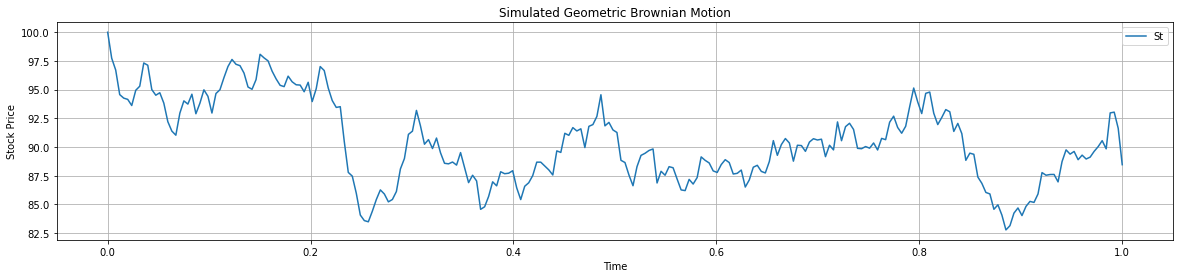

In [477]:
""" Geometric Brownian Motion - St Simulation"""
S0 = 100
sigma = .20
r = 0.06
T = 1.
M = 253
output = gbm_euler(S0, r, sigma, T, M)

temp_output = pd.DataFrame(output, columns=['St', 'Time'])
temp_output = temp_output.set_index('Time')
temp_output.plot(figsize=(20,4), grid=True, title="Simulated Geometric Brownian Motion", ylabel="Stock Price", label=f'Euler Method M={M}')

---------- Initial ---------- 
 V0 = 11.544690260826073 
 D0 = 0.6736807824006316 
 S0 = 100 
 Initial Balance = -55.82338797923708


>>> Re-balancing Frequency = WEEKLY
----------- Results ----------- 
 Option Payoff = 0 
 PnL = -0.1853250078326816 


,Stock Price,Time,Delta,Payoff,Balance
0,100.000000,0.000000,0.673681,1.154469e+01,-55.823388
1,97.739549,0.003953,0.673681,1.003984e+01,-55.836628
2,96.707234,0.007905,0.673681,9.373685e+00,-55.849872
3,94.566197,0.011858,0.673681,8.088833e+00,-55.863118
4,94.259403,0.015810,0.673681,7.888432e+00,-55.876368
...,...,...,...,...,...
249,89.839622,0.984190,0.001934,3.565248e-05,-0.157479
250,92.970925,0.988142,0.002232,1.324651e-03,-0.185193
251,93.037569,0.992095,0.002232,1.123655e-04,-0.185237
252,91.626940,0.996047,0.002232,6.936966e-11,-0.185281


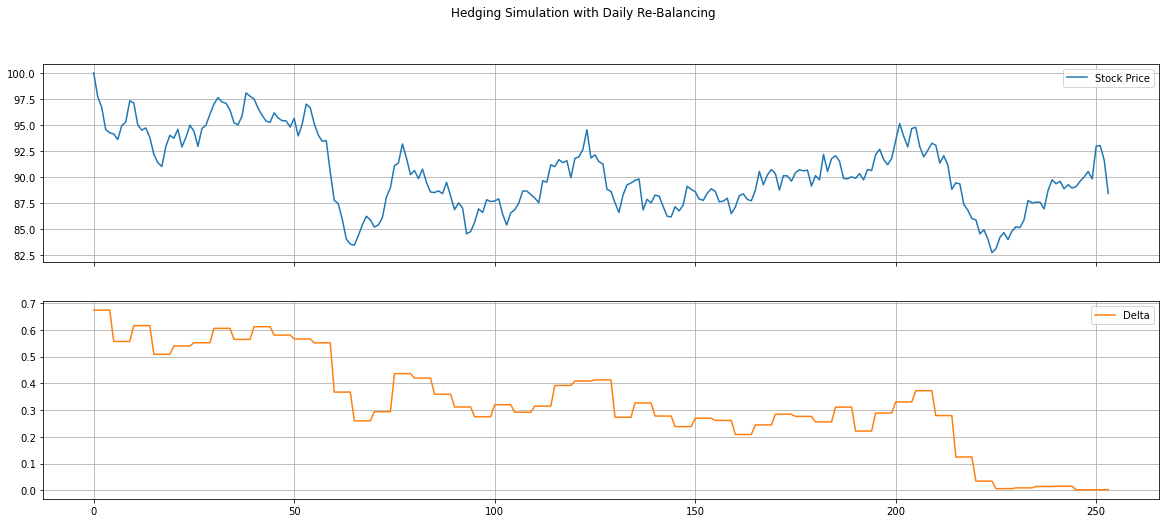

In [478]:
""" Option Parameters """
sigma = .20
r = 0.06
T = 1.
K = 99
V0, D0 = option_contract_bt(T, r , K, sigma, 1000, S0, type="C", american=False)
delta_hist = np.zeros((output.shape[0],3))  ;   dt = T/M

delta_hist[0, 0] = D0   ;   delta_hist[0, 1] =  V0  ;   delta_hist[0, 2] = V0 - D0 * S0     ;   Dt = D0
print(f'---------- Initial ---------- \n V0 = {V0} \n D0 = {D0} \n S0 = {S0} \n Initial Balance = {delta_hist[0, 2]}')

WEEKLY = 1   ;   print(f'\n\n>>> Re-balancing Frequency = {"WEEKLY" if WEEKLY else "DAILY"}')
for inx, st in enumerate(output[1:]):

    V_bt, D_bt = option_contract_bt(T-st[1], r , K, sigma, 1000, st[0], type="C", american=False)
    if WEEKLY:    Dt = D_bt if ((inx+1) % 5 == 0) else Dt
    else: Dt = D_bt

    """ Delta """
    delta_hist[inx+1,0] = Dt
    """ Payoff """
    delta_hist[inx+1, 1] = V_bt
    """ Balance """
    delta_hist[inx+1, 2] = delta_hist[inx, 2]*np.exp(r*dt)
    if WEEKLY:    delta_hist[inx+1, 2] += (delta_hist[inx,0] - Dt) * st[0] if ((inx+1) % 5 == 0) else 0
    else: delta_hist[inx+1, 2] += (delta_hist[inx,0] - Dt) * st[0]

if output[-1,0] >= K:
    """ (negative)Balance + Selling the stock - Call payoff """
    Payoff_T = output[-1,0] - K     ;   PnL = delta_hist[-1, 2] + output[-1,0]*delta_hist[-1, 1] - (output[-1,0] - K)
    print(f'----------- Results ----------- \n Option Payoff = {output[-1,0] - K} \n PnL = {PnL}')
else:
    """ Balance + Selling the stock """
    Payoff_T = 0     ;   PnL = delta_hist[-1, 2] + output[-1,0]*delta_hist[-1, 1]
    print(f'----------- Results ----------- \n Option Payoff = {0} \n PnL = {PnL} ')
result = np.append(output, np.array(delta_hist), axis=1)

""" Plotting """
# fig, ax_left = plt.subplots()
# ax_right = ax_left.twinx()

_results_df = pd.DataFrame(result, columns=['Stock Price', 'Time', 'Delta', 'Payoff', 'Balance'])
# _results_df.set_index('Time', inplace=True)

# _results_df[['Stock Price']].plot(figsize=(20,4), ax=ax_left, ylabel='Stock Price', legend=f'Euler Method M={M}',
#                               title='Hedging Simulation with Daily Re-Balancing', grid=True, logx=False)
# _results_df[['Delta']].plot(ax=ax_right, color='green', ylabel='Delta', legend='Delta', ylim=(-0.05, 1.05))
_results_df[['Stock Price','Delta']].plot(figsize=(20,8), subplots=True, title='Hedging Simulation with Daily Re-Balancing', grid=True)
_results_df #.plot(figsize=(20,12), subplots=True, title='Hedging Simulation with Daily Re-Balancing', grid=True)

In [303]:
100*np.exp(r*1)

106.18365465453596